<a href="https://colab.research.google.com/github/fjadidi2001/Artificial_Intelligence_Learning/blob/master/SVD_inpaint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# libraries

In [140]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, color
from matplotlib.image import imread
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import cv2
import cv2 as cv
from sklearn.decomposition import SparseCoder
from skimage.util import view_as_windows


# load image

In [141]:
def read_image(image_path):
    return io.imread(image_path)

# Gray level

In [142]:
def convert_to_grayscale(image):
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        return image
    return color.rgb2gray(image)


# mask

In [143]:
def create_mask(image_shape, mask_coords):
    mask = np.zeros(image_shape, dtype=bool)
    for (x, y, w, h) in mask_coords:
        mask[y:y+h, x:x+w] = True
    return mask


# patches

In [144]:

def extract_patches(image, patch_size):
    patches = view_as_windows(image, (patch_size, patch_size), step=patch_size)
    patches = patches.reshape(-1, patch_size, patch_size)
    return patches


# SVD

In [145]:
def perform_svd(patches):
    U_list, S_list, Vt_list = [], [], []
    for patch in patches:
        U, S, Vt = np.linalg.svd(patch, full_matrices=False)
        U_list.append(U)
        S_list.append(S)
        Vt_list.append(Vt)
    return U_list, S_list, Vt_list


# PCA

In [146]:
def perform_pca(patches, n_components):
    pca = PCA(n_components=n_components)
    patches_flat = patches.reshape(patches.shape[0], -1)
    pca.fit(patches_flat)
    return pca.components_, pca.mean_, pca

# patches from SVD

In [147]:
def reconstruct_patches_svd(U_list, S_list, Vt_list, k):
    reconstructed_patches = []
    for U, S, Vt in zip(U_list, S_list, Vt_list):
        S_k = np.zeros_like(S)
        S_k[:k] = S[:k]
        reconstructed_patch = np.dot(U, np.dot(np.diag(S_k), Vt))
        reconstructed_patches.append(reconstructed_patch)
    return np.array(reconstructed_patches)


# patches from PCA

In [148]:
def reconstruct_patches_pca(patches, components, mean, pca):
    patches_flat = patches.reshape(patches.shape[0], -1)
    patches_reconstructed_flat = pca.inverse_transform(pca.transform(patches_flat))
    return patches_reconstructed_flat.reshape(patches.shape)


# Computing Priority

In [149]:
def compute_priority(mask, confidence, patch_size):
    edge = cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)
    edge_coords = np.column_stack(np.where(edge > 0))
    priority = np.zeros_like(confidence)
    for y, x in edge_coords:
        patch = mask[y:y+patch_size, x:x+patch_size]
        if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
            continue
        priority[y, x] = confidence[y, x]
    return priority, edge_coords


# Finding Best Patch

In [150]:
def find_best_patch(image, mask, target_patch, patch_size):
    best_patch = None
    best_ssd = float('inf')
    for y in range(0, image.shape[0] - patch_size + 1):
        for x in range(0, image.shape[1] - patch_size + 1):
            patch = image[y:y+patch_size, x:x+patch_size]
            if not mask[y:y+patch_size, x:x+patch_size].any():
                ssd = np.sum((patch - target_patch) ** 2)
                if ssd < best_ssd:
                    best_ssd = ssd
                    best_patch = (y, x)
    return best_patch


# Inpainting with Criminisi Algorithm

In [151]:
# Function to perform inpainting using the Criminisi algorithm
def inpaint_criminisi(image, mask, patch_size, k, method='svd'):
    patches = extract_patches(image, patch_size)
    if method == 'svd':
        U_list, S_list, Vt_list = perform_svd(patches)
        reconstructed_patches = reconstruct_patches_svd(U_list, S_list, Vt_list, k)
    elif method == 'pca':
        components, mean, pca = perform_pca(patches, k)
        reconstructed_patches = reconstruct_patches_pca(patches, components, mean, pca)
    else:
        raise ValueError("Unsupported method. Use 'svd' or 'pca'.")

    confidence = 1.0 - mask.astype(np.float32)
    while mask.any():
        priority, edge_coords = compute_priority(mask, confidence, patch_size)
        y, x = edge_coords[np.argmax(priority[edge_coords[:, 0], edge_coords[:, 1]])]
        target_patch = image[y:y+patch_size, x:x+patch_size]
        best_y, best_x = find_best_patch(image, mask, target_patch, patch_size)
        if best_y is None or best_x is None:
            break
        best_patch = image[best_y:best_y+patch_size, best_x:best_x+patch_size]
        mask[y:y+patch_size, x:x+patch_size] = False
        image[y:y+patch_size, x:x+patch_size] = best_patch
        confidence[y:y+patch_size, x:x+patch_size] = 1.0
    return image

# display images

In [152]:
# Function to display the original, masked, and inpainted images, along with some patches
def display_images(original_image, masked_image, inpainted_image, patches):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs[0, 0].imshow(original_image, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(masked_image, cmap='gray')
    axs[0, 1].set_title('Masked Image')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(inpainted_image, cmap='gray')
    axs[0, 2].set_title('Inpainted Image')
    axs[0, 2].axis('off')

    for idx, patch in enumerate(patches[:3]):
        axs[1, idx].imshow(patch, cmap='gray')
        axs[1, idx].set_title(f'Patch {idx+1}')
        axs[1, idx].axis('off')

    plt.show()

In [153]:
def main(image_path, mask_coords, patch_size, k, method='svd'):
    original_image = read_image(image_path)
    grayscale_image = convert_to_grayscale(original_image)
    mask = create_mask(grayscale_image.shape, mask_coords)
    masked_image = np.copy(grayscale_image)
    masked_image[mask] = 0
    inpainted_image = inpaint(grayscale_image, mask, patch_size, k, method)
    patches = extract_patches(grayscale_image, patch_size)
    display_images(original_image, masked_image, inpainted_image, patches)





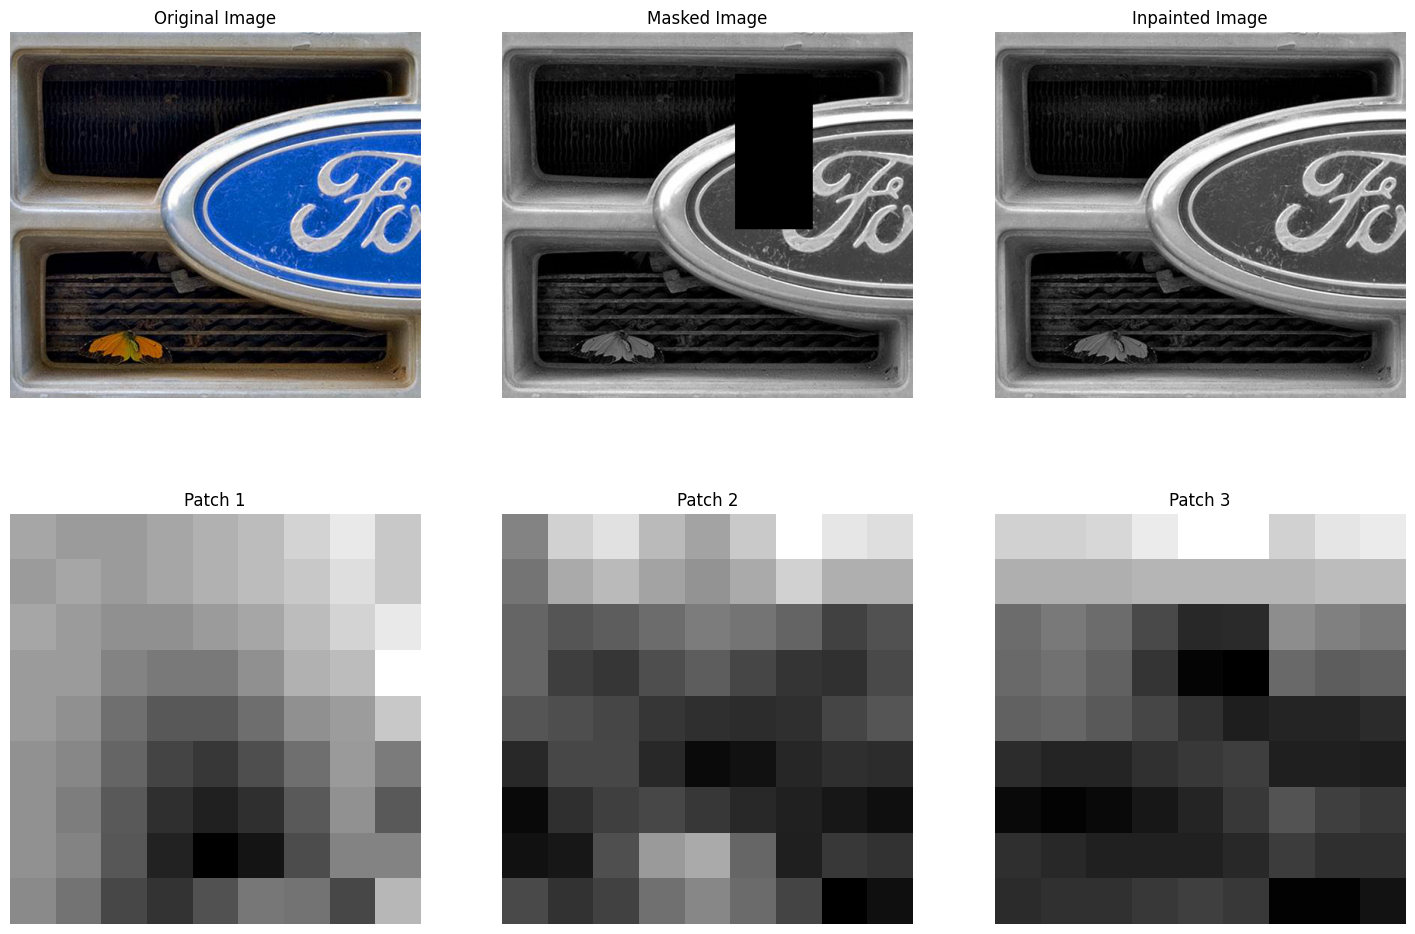

In [154]:
# Example Usage
image_path = '54.png'
mask_coords = [(300, 55, 100, 200)]  # Example coordinates (x, y, width, height)
patch_size = 9  # Example patch size
k = 50  # Top k% singular values to keep for SVD or top k principal components for PCA
method = 'svd'  # or 'pca'
main(image_path, mask_coords, patch_size, k, method)


Import Statements:

Import necessary libraries including numpy, skimage, matplotlib, PCA from sklearn, and cv2 for image processing.
Function read_image:

Reads an image from the given file path.
Function convert_to_grayscale:

Converts the image to grayscale if it's not already.
Function create_mask:

Creates a binary mask based on given coordinates.
Function extract_patches:

Extracts patches of the given size from the image.
Function perform_svd:

Performs SVD on each patch and returns the decomposed components.
Function perform_pca:

Performs PCA on the patches and returns the principal components and the mean.
Function reconstruct_patches_svd:

Reconstructs patches using the top k singular values from SVD.
Function reconstruct_patches_pca:

Reconstructs patches using the PCA components and mean.
Function compute_priority:

Computes the priority for the Criminisi inpainting algorithm based on edge detection and confidence values.
Function find_best_patch:

Finds the best matching patch in the image to fill the target patch based on SSD (sum of squared differences).
Function inpaint_criminisi:

Performs the Criminisi inpainting algorithm using either SVD or PCA for patch reconstruction.
Function display_images:

Displays the original image, masked image, inpainted image, and some extracted patches.
Function main:

Main function to execute the inpainting process. It reads the image, converts it to grayscale, creates a mask, performs inpainting, and displays the results.
Example Usage:

Example usage of the main function with specified parameters for image path, mask coordinates, patch size, k value, and method ('svd' or 'pca').